In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch

In [3]:
from src.OED import *
from src.DQN import *
from src.GA import *
from pde.Burgers2D import *

In [41]:
tensorboard_dir

'./tensorboard/DQN_4'

## Evaluating models

In [4]:
pde_system = Burgers2D(Burgers2DConfig())

### Old action space model 

In [39]:
seed = 1
run_num = 2
model_name = f'trained_model/Burgers2D_old_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Burgers2D_old_dqn_{run_num}_seed_{seed}_config.pt'

In [40]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [36]:
gym_config.old_action_space = True
dqn_old = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_old.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
old_a_all_ep_rewards, old_a_best_rewards, old_a_optimal_states_all = dqn_old.evaluate(50)

100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


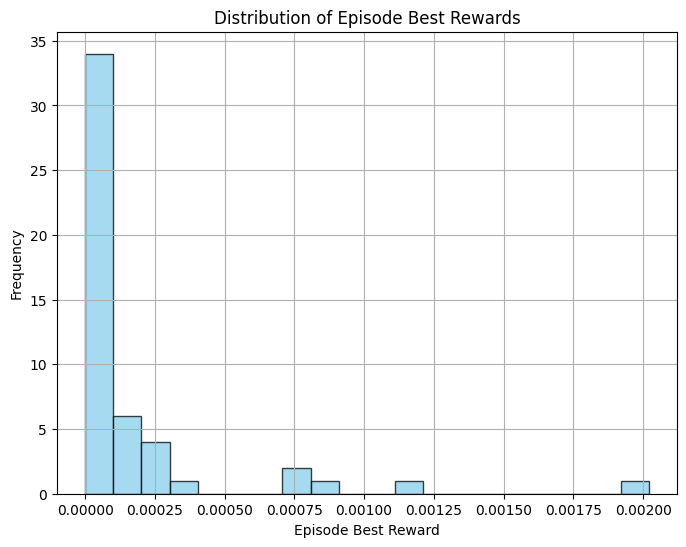

In [38]:
plt.figure(figsize=(8, 6))
plt.hist(old_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
# plt.axvline(x=ga_res['best_fitness'])
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
# plt.xscale('log')
plt.show()

In [67]:
tensorboard_dir

'./tensorboard/DQN_5'

### New Action space

In [74]:
seed = 1
run_num = 3
model_name = f'trained_model/Burgers2D_new_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Burgers2D_new_dqn_{run_num}_seed_{seed}_config.pt'

In [75]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [76]:
tensorboard_dir

'./tensorboard/DQN_5'

In [77]:
gym_config.old_action_space = False
dqn_new = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_new.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [78]:
new_a_all_ep_rewards, new_a_best_rewards, new_a_optimal_states_all = dqn_new.evaluate(num_episodes=20)

100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


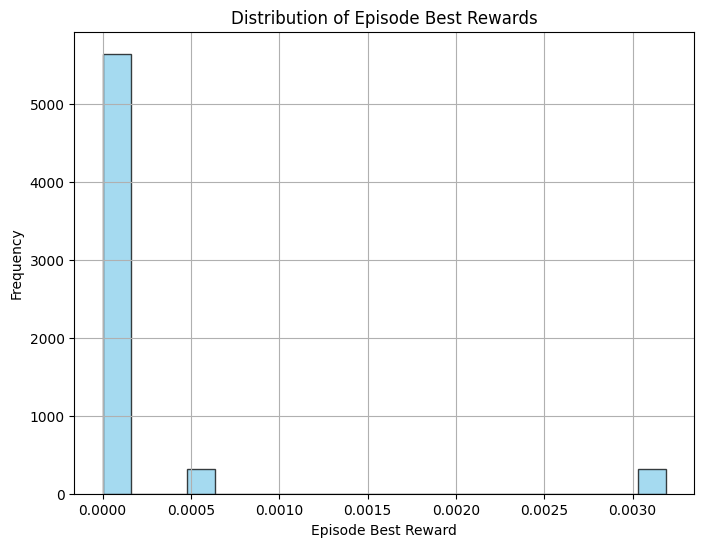

In [79]:
plt.figure(figsize=(8, 6))
plt.hist(new_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75, density=True)
# plt.axvline(x=ga_res['best_fitness'])
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
# plt.xscale('log')
plt.show()

### GA

In [18]:
ga_filename = "GAResults/Burgers2D_ga_2.mat"

In [21]:
ga_res = scipy.io.loadmat(ga_filename)

In [23]:
ga_res['best_fitness']

array([[0.07639063]])

## Plots

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource

In [50]:
env = dqn_old.env

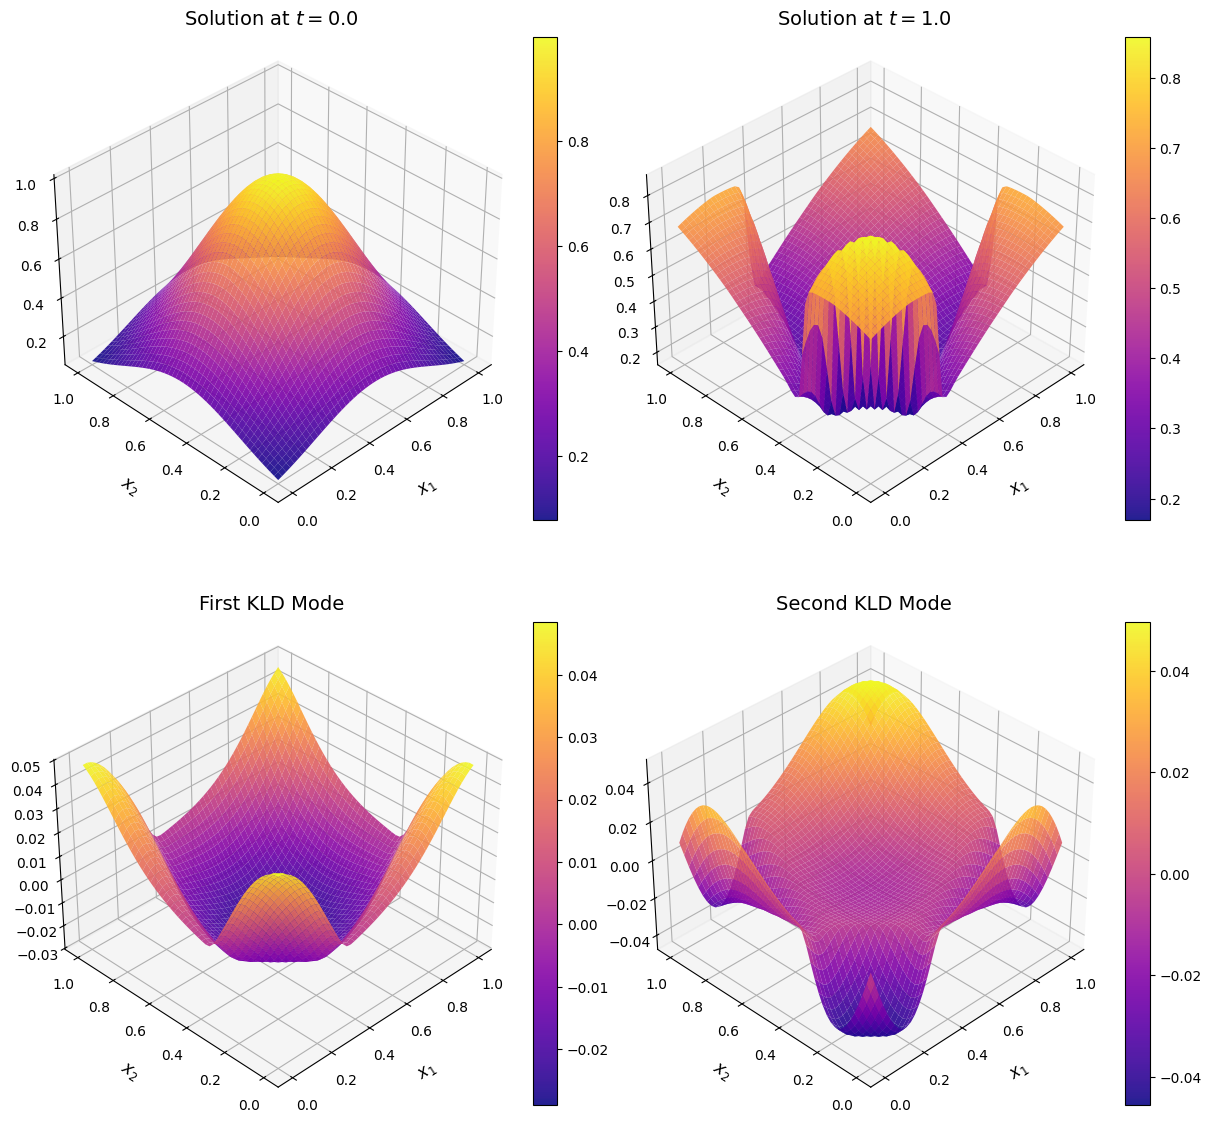

In [85]:
## Solution and Modes

fig = plt.figure(figsize=(12, 12)) 

x = np.linspace(0, 1, env.nx)
y = np.linspace(0, 1, env.ny)
X, Y = np.meshgrid(x, y)

datasets = [
    (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
    (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
    (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
    (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
]

for i, (data, title) in enumerate(datasets):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    
    ls = LightSource(azdeg=315, altdeg=-65)
    shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

    surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
    # ax.set_zlabel(r'$u(x_1, x_2)$', fontsize=12, labelpad=10)

    ax.view_init(elev=35, azim=-135)

    fig.colorbar(surf, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("3D_IB2d_2x2.png", dpi=400, bbox_inches='tight')


plt.show()


In [ ]:
# Old DQN: Training and reward

In [52]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

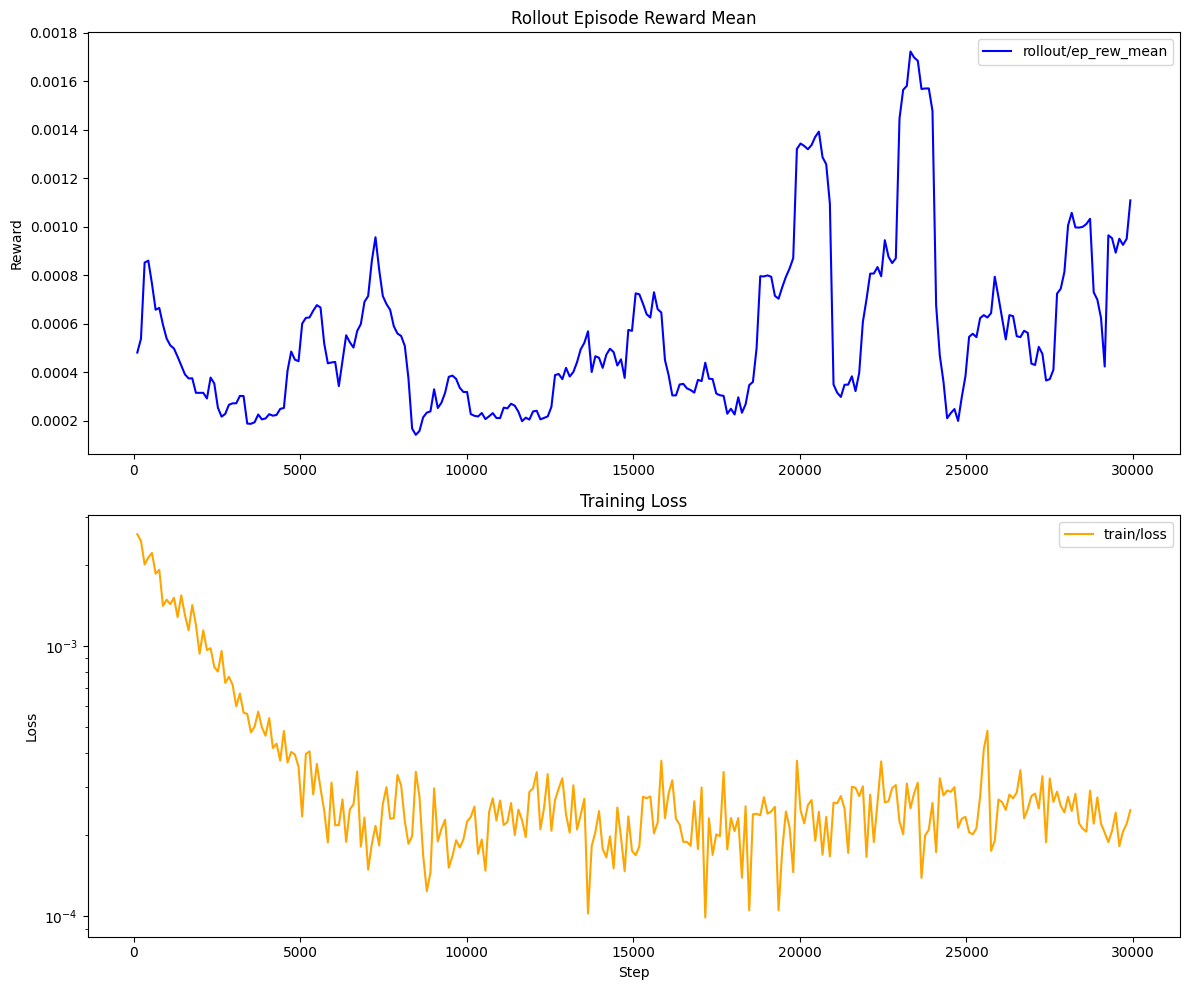

In [53]:
log_dir = 'trained_model/IB_old/DQN_4/'
tags = ['rollout/ep_rew_mean', 'train/loss']

# Load the TensorBoard data
ea = event_accumulator.EventAccumulator(
    log_dir,
    size_guidance={
        event_accumulator.SCALARS: 0,
    }
)
ea.Reload()

available_tags = ea.Tags()['scalars']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
df_rew_mean = pd.DataFrame(data_rew_mean)

ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
ax1.set_title('Rollout Episode Reward Mean')
# ax1.set_xlabel('Step')
ax1.set_ylabel('Reward')
ax1.legend()

data_loss = ea.Scalars('train/loss')
df_loss = pd.DataFrame(data_loss)

ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
ax2.set_title('Training Loss')
ax2.set_xlabel('Step')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
# plt.savefig("old_dqn_IB2d.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# New DQN: Training and reward

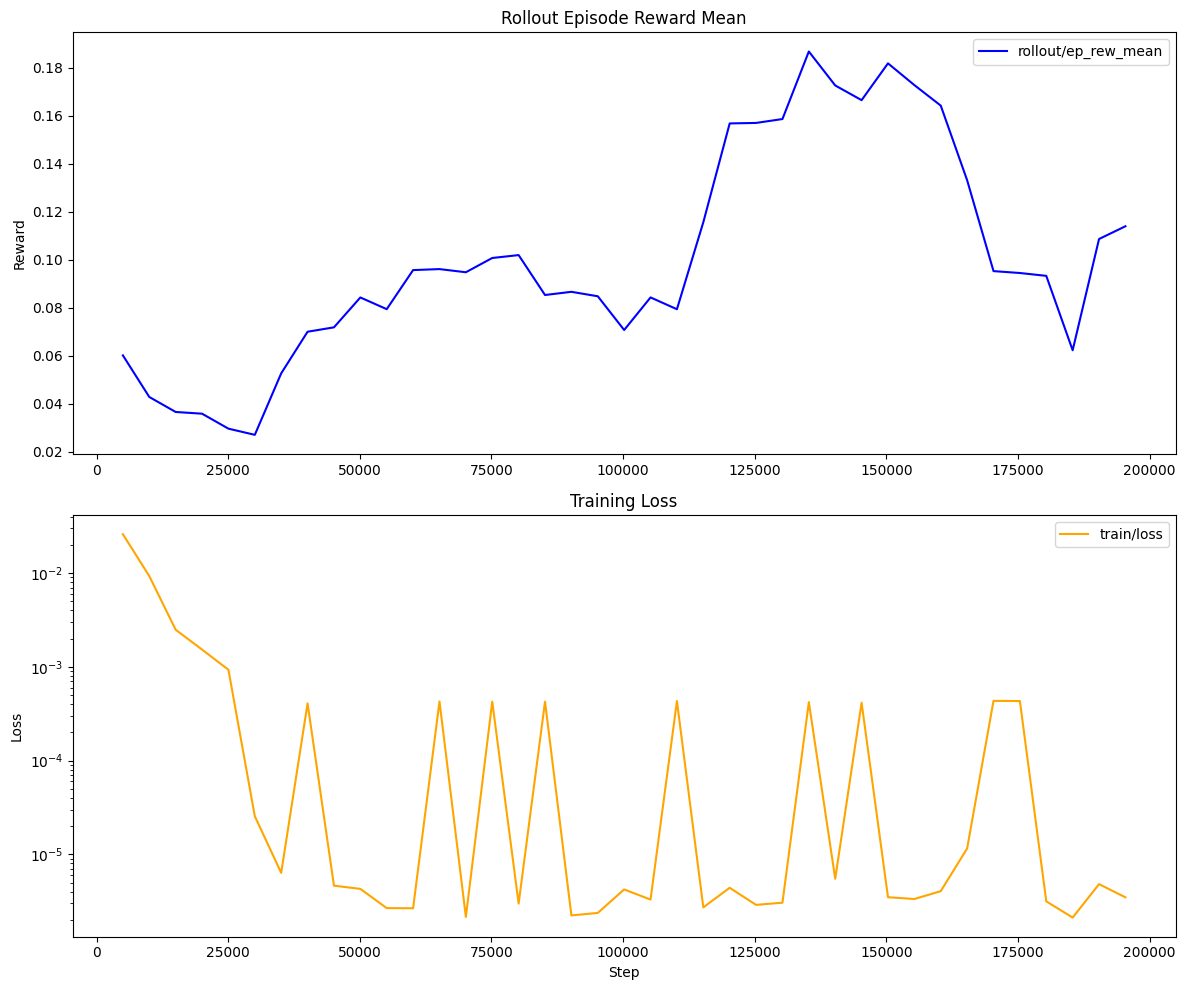

In [80]:
log_dir = 'trained_model/IB_new/DQN_5/'
tags = ['rollout/ep_rew_mean', 'train/loss']

# Load the TensorBoard data
ea = event_accumulator.EventAccumulator(
    log_dir,
    size_guidance={
        event_accumulator.SCALARS: 0,
    }
)
ea.Reload()

available_tags = ea.Tags()['scalars']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
df_rew_mean = pd.DataFrame(data_rew_mean)

ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
ax1.set_title('Rollout Episode Reward Mean')
# ax1.set_xlabel('Step')
ax1.set_ylabel('Reward')
ax1.legend()

data_loss = ea.Scalars('train/loss')
df_loss = pd.DataFrame(data_loss)

ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
ax2.set_title('Training Loss')
ax2.set_xlabel('Step')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
# plt.savefig("new_dqn_IB2d.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# Reward distribution comparison

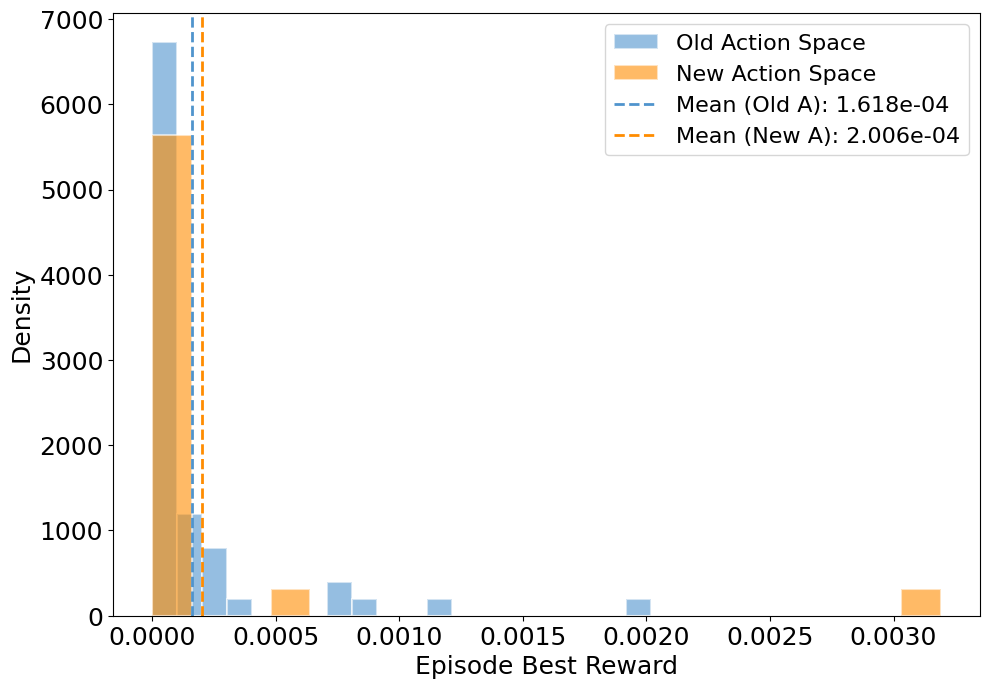

In [86]:
plt.figure(figsize=(10, 7))
plt.hist(old_a_best_rewards, bins=20, 
         color='#4F94CD',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='Old Action Space')

plt.hist(new_a_best_rewards, bins=20, 
         color='#FF8C00',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='New Action Space')

mean_old = np.mean(old_a_best_rewards)
mean_new = np.mean(new_a_best_rewards)
ga_best = ga_res['best_fitness'][0][0]

plt.axvline(x=mean_old, color='#4F94CD', linestyle='--', linewidth=2, label=f'Mean (Old A): {mean_old:.3e}')
plt.axvline(x=mean_new, color='#FF8C00', linestyle='--', linewidth=2, label=f'Mean (New A): {mean_new:.3e}')
# plt.axvline(x=ga_best, color='g', linestyle='--', linewidth=2, label=f'GA (Best): {ga_best:.2f}')

plt.xlabel('Episode Best Reward', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("IB2d_res_hist.png", dpi=400, bbox_inches='tight')
plt.show()

In [59]:
ga_best

np.float64(0.07639062543678565)